In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob

import cftime

import numpy as np
import dask
from dask.distributed import Client
import xarray as xr

import matplotlib.pyplot as plt

import oae_smyle
import project

In [3]:
df_caseinfo = oae_smyle.get_caseinfo(attempt="001")
df_caseinfo

,build,submitted,running,run,archive,error,error_count,yr_per_day
case,,,,,,,,
smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001,True,True,True,True,True,False,0,55.91
smyle.oae-map.North_Atlantic_basin.000.1999-07-01.001,True,True,True,True,True,False,0,56.79
smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001,True,True,True,True,True,False,0,55.55
smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001,True,True,True,True,True,False,0,55.20
smyle.oae-map.North_Atlantic_basin.001.1999-07-01.001,True,True,True,True,True,False,0,55.57
...,...,...,...,...,...,...,...,...
smyle.oae-map.Southern_Ocean.035.1999-10-01.001,True,True,True,True,True,False,0,61.34
smyle.oae-map.Southern_Ocean.036.1999-10-01.001,True,True,True,True,True,False,0,59.78
smyle.oae-map.Southern_Ocean.037.1999-10-01.001,True,True,True,True,True,False,0,60.00


In [4]:
caselist = df_caseinfo.loc[(df_caseinfo.run) & (~df_caseinfo.error)].index.to_list()
caselist

['smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.000.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.001.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.001.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.002.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.002.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.002.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.003.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.003.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.003.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.004.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.004.1999-07-01.001',
 'smyle.oae-map.North_Atlantic_basin.004.1999-10-01.001',
 'smyle.oae-map.North_Atlantic_basin.005.1999-04-01.001',
 'smyle.oae-map.North_Atlantic_basin.005.1999-10-01.001',
 'smyle.oae-ma

In [5]:
scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler_file.json")

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status" 
client = Client(scheduler_file=scheduler_file)
client

<Client: 'tcp://10.249.1.88:8786' processes=64 threads=16384, memory=29.79 TiB>

In [6]:
clobber = False

dir_out = f"{project.dir_data}/Case-Validation"
os.makedirs(dir_out, exist_ok=True)

dsets = {}
for case in caselist:
    print(case)   
    zarr_store =  f"{dir_out}/{case}.additionality.zarr"
               
    if not os.path.exists(zarr_store) or clobber:    
        ds = oae_smyle.open_dataset(case, stream="pop.h")    
        fg_co2 = oae_smyle.compute_additional_CO2_flux(ds)
        add_co2 = oae_smyle.compute_additional_DIC_global_ts(ds)
        
        dso = xr.Dataset({'add_dic': add_co2, 'add_fg_co2': fg_co2}) 
        
        dso = dso.compute()
        
        dso.to_zarr(
            zarr_store,
            mode="w",
            consolidated=True,
        )
    else:
        dso = xr.open_zarr(zarr_store).compute()
        
    dsets[case] = dso

smyle.oae-map.North_Atlantic_basin.000.1999-04-01.001
smyle.oae-map.North_Atlantic_basin.000.1999-07-01.001
smyle.oae-map.North_Atlantic_basin.000.1999-10-01.001
smyle.oae-map.North_Atlantic_basin.001.1999-04-01.001
smyle.oae-map.North_Atlantic_basin.001.1999-07-01.001
smyle.oae-map.North_Atlantic_basin.001.1999-10-01.001
smyle.oae-map.North_Atlantic_basin.002.1999-04-01.001
smyle.oae-map.North_Atlantic_basin.002.1999-07-01.001
smyle.oae-map.North_Atlantic_basin.002.1999-10-01.001
smyle.oae-map.North_Atlantic_basin.003.1999-04-01.001
smyle.oae-map.North_Atlantic_basin.003.1999-07-01.001
smyle.oae-map.North_Atlantic_basin.003.1999-10-01.001
smyle.oae-map.North_Atlantic_basin.004.1999-04-01.001
smyle.oae-map.North_Atlantic_basin.004.1999-07-01.001
smyle.oae-map.North_Atlantic_basin.004.1999-10-01.001
smyle.oae-map.North_Atlantic_basin.005.1999-04-01.001
smyle.oae-map.North_Atlantic_basin.005.1999-10-01.001
smyle.oae-map.North_Atlantic_basin.006.1999-04-01.001
smyle.oae-map.North_Atlantic

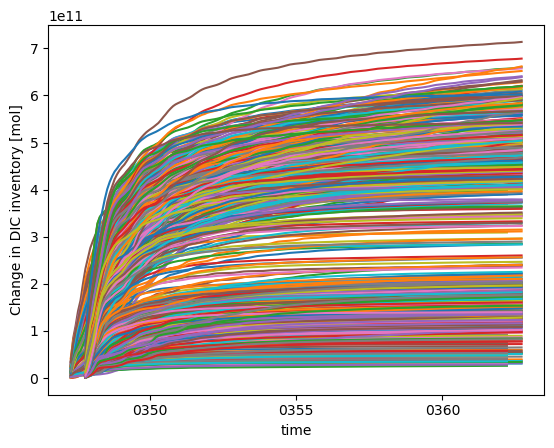

In [7]:
for key, ds in dsets.items():
    ds.add_dic.plot()

In [8]:
#plt.rcParams.update({'figure.max_open_warning': 0})
#for key, ds in dsets.items():
#    plt.figure()
#    ds.add_fg_co2.isel(time=11).plot()
#    plt.title(key)